In [1]:
import math
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import random
import warnings

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
florida = pd.read_excel('./florida_2017.xls')
headers = ['city', 'population', 'violent_crime', 'murder', 'rape', 'robbery',
       'assault', 'property_crime', 'burglary', 'larceny_theft',
       'motor_vehicle_theft', 'arson']
florida.columns = headers
florida.set_index('city', inplace=True)

In [3]:
crime_cols = ['violent_crime', 'murder', 'rape', 'robbery', 
              'assault', 'property_crime', 'burglary', 'larceny_theft', 
              'motor_vehicle_theft', 'arson']
# so we will want to remove some outliers
florida = florida[florida.population<florida.population.quantile(0.9)]

In [4]:
# add a log odds variable (do not include property crimes though)
cols = ['violent_crime', 'murder', 'rape', 'robbery', 
        'assault', 'burglary', 'larceny_theft', 
        'motor_vehicle_theft', 'arson']
florida["log_odds"] = np.log1p(florida.population / florida[cols].sum(axis=1))

In [5]:
# log population
florida["population_log"] = np.log(florida.population)

# log1p first adds 1 to x then logs the result
florida["property_crime_log"] = np.log1p(florida.property_crime)

# create a population_medium indicator variable
# these are going to be relative to the population in each state
# the medium group is the interquartile range on population (between 1st and 3rd quantiles)
florida["population_medium"] = (florida.population.between(3620.0, 24929.5)).astype("int")

# create n population groups
florida["population_group"] = pd.cut(florida.population, 5, labels=list(range(1,6)))

# create robbery dummy var
florida["has_robbery"] = np.where(florida.robbery>0,1,0)

# because box-cox transforms require x>0, when property_crime is 0 we add 1, else we leave it alone
florida["property_crime_2"] = florida["property_crime"].apply(lambda x: x+1 if x == 0 else x)

# burglary_cube_root
florida["burglary_cube_root"] = florida.burglary**(1/3)

# assault_log
florida["assault_log"] = np.log1p(florida.assault)

# larceny_theft_cube_root
florida["larceny_theft_cube_root"] = florida.larceny_theft ** (1/3)

# robbery_log
florida["robbery_log"] = np.log1p(florida.robbery)

# motor_vehicle_theft_log
florida["motor_vehicle_theft_log"] = np.log1p(florida.motor_vehicle_theft)

In [6]:
bc1 = boxcox(florida["property_crime_2"])
florida['property_crime_bc'] = bc1[0]
florida_bc_lambda = bc1[1]

In [7]:
florida_train = florida.sample(frac=0.7, random_state=41)
florida_test_cities = list(set(florida.index).difference(set(florida_train.index)))
florida_test = florida.loc[florida_test_cities,:]
print("Train shape: {}".format(florida_train.shape))
print("Test shape: {}".format(florida_test.shape))

Train shape: (178, 24)
Test shape: (77, 24)


In [8]:
# Now lets see how well we can predict the boxcox transform of property_crime

model_vars = ['population_log', 'has_robbery', 
              'population_medium',
              "robbery_log", "burglary_cube_root",
              "larceny_theft_cube_root", "motor_vehicle_theft_log"]

X = florida_train[model_vars]
y = florida_train["property_crime_bc"]

model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [9]:
def evaluate_pslr_model(X, y, n_components):
    # Fit a linear model with all 10 features.
    regr = linear_model.LinearRegression()
    regr.fit(X, y)

    # Save predicted values.
    Y_pred = regr.predict(X)
    print('R-squared regression:', regr.score(X, y))

    # Fit a linear model using Partial Least Squares Regression.
    # Reduce feature space to 3 dimensions.
    pls1 = PLSRegression(n_components=n_components)

    # Reduce X to R(X) and regress on y.
    pls1.fit(X, y)

    # Save predicted values.
    Y_PLS_pred = pls1.predict(X)
    print('R-squared PLSR:', pls1.score(X, y))

    # Compare the predictions of the two models
    plt.scatter(Y_pred,Y_PLS_pred) 
    plt.xlabel('Predicted by original 10 features')
    plt.ylabel('Predicted by 3 features')
    plt.title('Comparing LR and PLSR predictions')
    plt.show()
    return (Y_pred, Y_PLS_pred)

R-squared regression: 0.992875090110715
R-squared PLSR: 0.9928747923772733


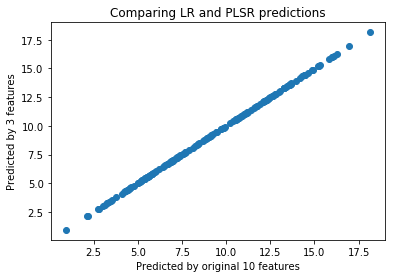

In [10]:
(Y_pred, Y_PLS_pred6) = evaluate_pslr_model(X, y, 6)

R-squared regression: 0.992875090110715
R-squared PLSR: 0.9928494458121468


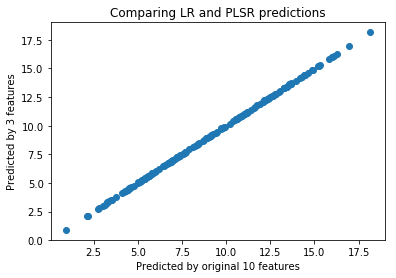

In [26]:
(Y_pred, Y_PLS_pred5) = evaluate_pslr_model(X, y, 5)

R-squared regression: 0.992875090110715
R-squared PLSR: 0.9919076410804375


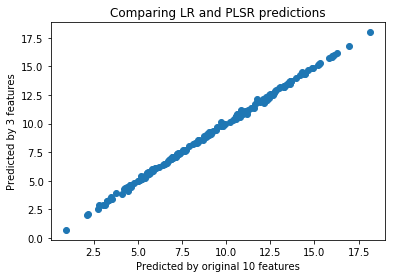

In [27]:
(Y_pred, Y_PLS_pred4) = evaluate_pslr_model(X, y, 4)

R-squared regression: 0.992875090110715
R-squared PLSR: 0.9859791077255515


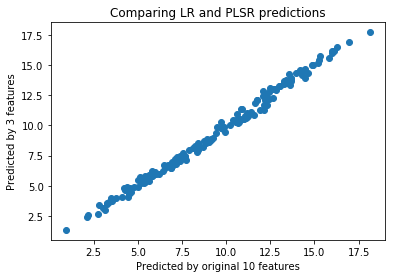

In [28]:
(Y_pred, Y_PLS_pred3) = evaluate_pslr_model(X, y, 3)

R-squared regression: 0.992875090110715
R-squared PLSR: 0.9776519913096948


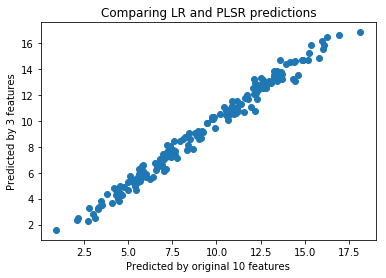

In [29]:
(Y_pred, Y_PLS_pred2) = evaluate_pslr_model(X, y, 2)

R-squared regression: 0.992875090110715
R-squared PLSR: 0.9641878558256956


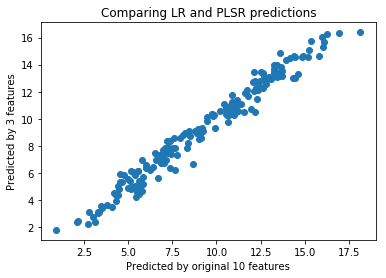

In [30]:
(Y_pred, Y_PLS_pred1) = evaluate_pslr_model(X, y, 1)

In [32]:
# get these prediction back to property_crime (right now property_crime_bc)
predicted6 = inv_boxcox(Y_PLS_pred6, florida_bc_lambda)
residuals6 = florida_train["property_crime"].values - predicted6
print("Average Residual: {}\nRMSE: {}".format(residuals6.mean(), residuals6.std()))

Average Residual: -14.952154942633944
RMSE: 1079.784106904346


In [33]:
# get these prediction back to property_crime (right now property_crime_bc)
predicted5 = inv_boxcox(Y_PLS_pred5, florida_bc_lambda)
residuals5 = florida_train["property_crime"].values - predicted5
print("Average Residual: {}\nRMSE: {}".format(residuals5.mean(), residuals5.std()))

Average Residual: -15.0587462881256
RMSE: 1080.345238202234


In [34]:
# get these prediction back to property_crime (right now property_crime_bc)
predicted4 = inv_boxcox(Y_PLS_pred4, florida_bc_lambda)
residuals4 = florida_train["property_crime"].values - predicted4
print("Average Residual: {}\nRMSE: {}".format(residuals4.mean(), residuals4.std()))

Average Residual: -11.25601448748528
RMSE: 1066.9751779410103


In [35]:
# get these prediction back to property_crime (right now property_crime_bc)
predicted3 = inv_boxcox(Y_PLS_pred3, florida_bc_lambda)
residuals3 = florida_train["property_crime"].values - predicted3
print("Average Residual: {}\nRMSE: {}".format(residuals3.mean(), residuals3.std()))

Average Residual: -20.527359416875115
RMSE: 1086.563391169296


In [36]:
# get these prediction back to property_crime (right now property_crime_bc)
predicted2 = inv_boxcox(Y_PLS_pred2, florida_bc_lambda)
residuals2 = florida_train["property_crime"].values - predicted2
print("Average Residual: {}\nRMSE: {}".format(residuals2.mean(), residuals2.std()))

Average Residual: -3.123798823673391
RMSE: 1038.0104351582154


In [37]:
# get these prediction back to property_crime (right now property_crime_bc)
predicted1 = inv_boxcox(Y_PLS_pred1, florida_bc_lambda)
residuals1 = florida_train["property_crime"].values - predicted1
print("Average Residual: {}\nRMSE: {}".format(residuals1.mean(), residuals1.std()))

Average Residual: 6.257827888722345
RMSE: 1017.5217876709307


**Using only 1 component we get the best combination of mean error and RMSE!**

R-squared regression: 0.9890800278642469
R-squared PLSR: 0.950968815934705


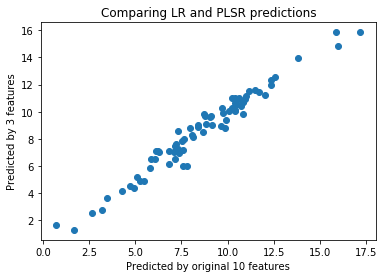

In [14]:
# X and Y now need to represent the test set
X_test = florida_test[model_vars]
y_test = florida_test["property_crime_bc"]

model_test = LinearRegression()
model_test.fit(X_test, y_test)

(Y_pred1_test, Y_PLS_pred1_test) = evaluate_pslr_model(X_test, y_test, 1)

In [15]:
# get these prediction back to property_crime (right now property_crime_bc)
predicted1_test = inv_boxcox(Y_PLS_pred1_test, florida_bc_lambda)
residuals1_test = florida_test["property_crime"].values - predicted1_test
print("Average Residual: {}\nRMSE: {}".format(residuals1_test.mean(), residuals1_test.std()))

Average Residual: 7.668273047279359
RMSE: 742.0842647286122


Not bad! The mean error increased by a little over 1, but the RMSE decreased by 27% and we used PLSR with only 1 component.